In [2]:
import os
import cv2
import tensorflow
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
import numpy as np
import pandas
import datetime as dt

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
# Um Grafiken zu plotten
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn

In [6]:
# Anzahl der Farbkanäle
numberOfChannels = 1

In [5]:
# Lade Bilder in eine Liste
images = []
# Hier können die Datensätze ausgewählt werden
datasets = ['15','16']
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("E:/bachelor/daten/" + dataset + "/zugeschnitten/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        print(filesPath)
        files = os.listdir(filesPath)
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            img = cv2.imread(filesPath + name, cv2.COLOR_BGR2GRAY)  # Bild wird gelesen   
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Von Farbkanal auf Grauwerte
            images.append(img) 

E:/bachelor/daten/15/zugeschnitten/1/
E:/bachelor/daten/15/zugeschnitten/2/
E:/bachelor/daten/15/zugeschnitten/3/
E:/bachelor/daten/15/zugeschnitten/4/
E:/bachelor/daten/15/zugeschnitten/5/
E:/bachelor/daten/15/zugeschnitten/6/
E:/bachelor/daten/15/zugeschnitten/7/
E:/bachelor/daten/15/zugeschnitten/8/
E:/bachelor/daten/16/zugeschnitten/1/
E:/bachelor/daten/16/zugeschnitten/2/
E:/bachelor/daten/16/zugeschnitten/3/
E:/bachelor/daten/16/zugeschnitten/4/
E:/bachelor/daten/16/zugeschnitten/5/
E:/bachelor/daten/16/zugeschnitten/6/
E:/bachelor/daten/16/zugeschnitten/7/
E:/bachelor/daten/16/zugeschnitten/8/


In [8]:
img_data = np.array(images)
img_data = img_data.astype('float32')
# Transfomierung der Bildpunkte auf den Wetebereich von 0 bis 1
img_data /= 255
print (img_data.shape)

(27856, 362, 70)


In [9]:
# Für Tensorflow Backend müssen die Anzahl der Farbkanäle als letzte Dimension angegeben werden in dem Array
if numberOfChannels == 1:
    img_data= img_data[:,np.newaxis]
    img_data=np.rollaxis(img_data,numberOfChannels,4)
    print (img_data.shape)

(27856, 362, 70, 1)


In [14]:
# Lese Merkmale
featuresDf = pandas.read_csv(filepath_or_buffer="../daten/merkmale.csv") 
featuresDf.head(2)

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,AccelerometerX,AccelerometerY,AccelerometerZ,Azimuth,Nick,Roll,...,VarianzY,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll,Klasse
0,1521123854573,53.613518,10.137816,6.624,0.66929 0.81137 0.75647 0.22221 -0.14389 -0.13...,0.583 0.4817 0.38533 -1.20873 -0.46135 -0.7521...,-0.07235 -0.30311 -0.074 0.17058 0.70334 0.194...,0.99199 0.87772 0.76088 1.53272 1.34296 1.4003...,-0.03752 -0.04402 -0.03939 0.1679 0.10177 0.15...,-0.238 -0.28304 -0.29204 -0.23407 -0.18064 -0....,...,0.26106,0.15991,0.00529,0.00475,0.39750,0.51094,0.39989,0.07273,0.06892,1
1,1521123855766,53.613520,10.137841,5.688,0.2285 0.13695 0.37016 0.08172 -0.05709 0.3834...,0.2865 -0.61359 -0.29171 0.80856 0.43231 0.851...,-1.01503 -0.09191 0.78449 0.9493 -0.26725 -0.6...,1.45444 1.7555 1.67776 1.33462 1.33851 1.0452 ...,0.02886 0.16383 0.13474 0.00472 0.01569 -0.064...,-0.22276 -0.19765 -0.21455 -0.18127 -0.18342 -...,...,0.26621,0.41180,0.00656,0.00844,0.41007,0.51596,0.64172,0.08099,0.09187,1


In [32]:
numberOfClasses = featuresDf['Klasse'].max() + 1 # Plus 1 weil 0 als Klase mitgezählt wird
featuresDf['Klasse'].max() +1 

4

In [15]:
num_of_samples = img_data.shape[0]
labelsNp = np.ones((num_of_samples,),dtype='int32')

In [17]:
# Von den Dataframe wird die letzte Spalte "Klasse" selektiert 
labelsNp = featuresDf.iloc[:,-1]
labelsNp.head(5)

0    1
1    1
2    2
3    0
4    0
Name: Klasse, dtype: int64

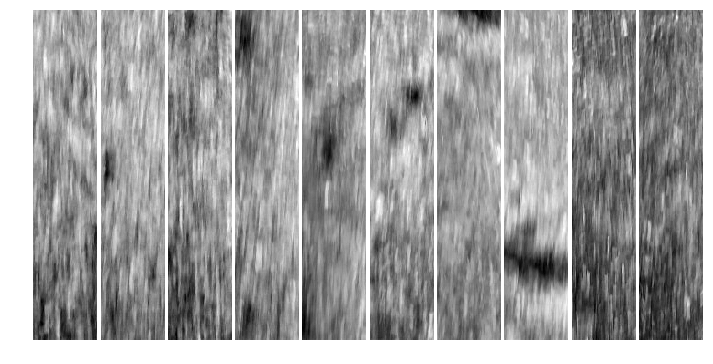

In [21]:
# Plot Beispiel Bilder
fig = plt.figure(1, figsize=(12,12))
# Anzahl der Bilder >= 10
imageToShow = 10
# Start Index des ersten Bildes
startIndex = 4400
grid = ImageGrid(fig, 111, nrows_ncols=(int(imageToShow/10), 10), axes_pad=0.05)
for i, img in enumerate(images[startIndex: startIndex + imageToShow]):
    ax = grid[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

In [22]:
# Erstellt einen "one hot encoding" für die gelabelten Daten
Y = np_utils.to_categorical(labelsNp, 0)

In [23]:
# Setzten des RandomState um reproduzierbare Ergebnisse zu erzielen.
np.random.seed(9)

In [24]:
# Mischen der Trainingsdaten
x,y = shuffle(img_data,Y)
# Aufteilung in Trainings und Testdaten
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [25]:
# Parameter für das CNN
input_shape    = img_data[0].shape
numNeurons_C1  = 32     
numNeurons_C2  = 64     
numNeurons_D1  = 64    
convKernelSize = 3    

In [33]:
model = Sequential()

model.add(Conv2D(numNeurons_C1, (convKernelSize, convKernelSize), padding='valid',input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(numNeurons_C2, (convKernelSize, convKernelSize)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(numNeurons_D1))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(numberOfClasses))
model.add(Activation('softmax'))

In [34]:
# Zusammenfassung des neuralen Netzes
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 360, 68, 32)       320       
_________________________________________________________________
activation_4 (Activation)    (None, 360, 68, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 180, 34, 32)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 180, 34, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 178, 32, 64)       18496     
_________________________________________________________________
activation_5 (Activation)    (None, 178, 32, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 16, 64)        0         
__________

In [35]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

In [36]:
%%time
num_epoch=10
hist = model.fit(X_train, y_train, batch_size=16, epochs=num_epoch, verbose=1, validation_data=(X_test, y_test))

Train on 22284 samples, validate on 5572 samples
Epoch 1/10
22284/22284 [==============================] - 183s 8ms/step - loss: 1.1403 - acc: 0.5285 - val_loss: 1.0989 - val_acc: 0.5318
Epoch 2/10
22284/22284 [==============================] - 97s 4ms/step - loss: 1.1193 - acc: 0.5292 - val_loss: 1.1424 - val_acc: 0.5318
Epoch 3/10
22284/22284 [==============================] - 97s 4ms/step - loss: 1.1084 - acc: 0.5292 - val_loss: 1.1068 - val_acc: 0.5318
Epoch 4/10
22284/22284 [==============================] - 99s 4ms/step - loss: 1.1032 - acc: 0.5292 - val_loss: 1.0939 - val_acc: 0.5318
Epoch 5/10
22284/22284 [==============================] - 96s 4ms/step - loss: 1.1031 - acc: 0.5292 - val_loss: 1.0930 - val_acc: 0.5318
Epoch 6/10
22284/22284 [==============================] - 96s 4ms/step - loss: 1.0996 - acc: 0.5292 - val_loss: 1.0992 - val_acc: 0.5318
Epoch 7/10
22284/22284 [==============================] - 96s 4ms/step - loss: 1.0992 - acc: 0.5292 - val_loss: 1.0932 - val_acc

NameError: name 'save_fig' is not defined

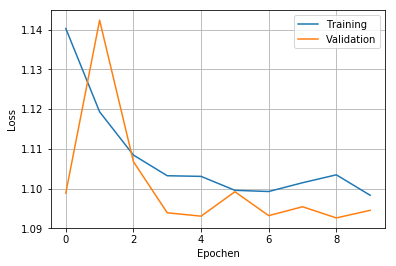

In [38]:
plt.figure(4)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.grid(True)
save_fig('Versuch_1_Loss')
plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.grid(True)
plt.savefig('Versuch_3_Genauigkeit')
plt.show()